# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

# Оглавление
1. [Шаг 1. Открытие файла с данными и изучение общей информации](#step1)

2. [Шаг 2. Предобработка данных:](#step2)<br>
 2.1. [Исследование пропусков в таблице и замена релевантными значениями](#step2-1)<br>
 2.2. [Приведение типов данных](#step2-2)<br>
 
3. [Шаг 3. Добавление новых данных в таблицу:](#step-3)<br>
 3.1. [Цена квадратного метра](#step3-1)<br>
 3.2. [День недели, месяц, год](#step3-2)<br>
 3.3. [Соотношение жилплощади и кухни ко всей площади](#step3-3)<br>
 3.4. [Этаж квартиры: первый, последний, другой](#step3-4)<br>
 
4. [Шаг 4. Исследовательский анализ:](#step-4)<br>
 4.1. [Изучение площади, цены, числа комнат и высоты потолка](#step4-1)<br>
 4.2. [Гистограммы распределения](#step4-2)<br>
 4.3. [Время продажи квартиры](#step4-3)<br>
 4.4. [Удаление редких и выбивающихся значений](#step4-4)<br>

# Шаг 1. Открытие файла с данными и изучение общей информации 
<a id="step1"></a> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./datasets/real_estate.csv', sep = '\t')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Вывод

В таблице много пропущенных данных. Причины могут быть разными: данные отсутствуют, например, в квартире нет балкона и вместо нуля проставился NaN, либо их не заполняли при отправке анкеты. Какие-то можно будет заполнить нулями, какие-то средним.

Многие поля имеют тип float, хотя лучше использовать для них int, поскольку значения в них целочисленные. После обработки пропусков изменю типы данных на подходящие.

##### Вопросы:
- Почему возникли пропуски? 
- Как будем их заполнять?
- Что с типами данных, они корректные?

# Шаг 2. Предобработка данных 
<a id="step2"></a>

## Исследование пропусков в таблице и замена релевантными значениями 
<a id="step2-1"></a>

определите и изучите пропущенные значения:
для некоторых пропущенных значений можно предположить логичную замену. Например, если человек не указал число балконов — скорее всего, их нет. Такие пропуски правильно заменить на 0. Для других типов данных нет подходящего значения на замену. В этом случае правильно оставить эти значения пустыми. Отсутствие значения — тоже важный сигнал, который не нужно прятать;
заполните пропуски, где это уместно. Опишите, почему вы решили заполнить пропуски именно в этих столбцах и как выбрали значения;
укажите причины, которые могли привести к пропускам в данных.
приведите данные к нужным типам:
поясните, в каких столбцах нужно изменить тип данных и почему.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [3]:
#Проверяем пропуски NaN во всех столбцах
# Если кол-во пропусков меньше 1%, то их игнорировал
def print_nan(row):
    
    nan_count = row.isna().sum()
    nan_percent = row.isna().sum() / df.shape[0]

    if nan_count > 0:
        if nan_percent > 0.01:
            print('{}: {};'.format(row.name, row.isna().sum()),
                  '{:.1%}'.format(row.isna().sum() / df.shape[0]), '\n')

#Методом .apply() применил функцию print_nan() к датафрейму по столбцам        
print('Пропуски:')
df.apply(print_nan, axis = 0)

Пропуски:
ceiling_height: 9195; 38.8% 

living_area: 1903; 8.0% 

is_apartment: 20924; 88.3% 

kitchen_area: 2278; 9.6% 

balcony: 11519; 48.6% 

airports_nearest: 5542; 23.4% 

cityCenters_nearest: 5519; 23.3% 

parks_around3000: 5518; 23.3% 

parks_nearest: 15620; 65.9% 

ponds_around3000: 5518; 23.3% 

ponds_nearest: 14589; 61.6% 

days_exposition: 3181; 13.4% 



total_images            None
last_price              None
total_area              None
first_day_exposition    None
rooms                   None
ceiling_height          None
floors_total            None
living_area             None
floor                   None
is_apartment            None
studio                  None
open_plan               None
kitchen_area            None
balcony                 None
locality_name           None
airports_nearest        None
cityCenters_nearest     None
parks_around3000        None
parks_nearest           None
ponds_around3000        None
ponds_nearest           None
days_exposition         None
dtype: object

Много пропусков по высоте потолка. Прежде, чем их заполнить, проверим, есть ли выбросы. Аналогичное позже проделаю и с жилой площадью, кухней.

### Проверяем высоту потолков

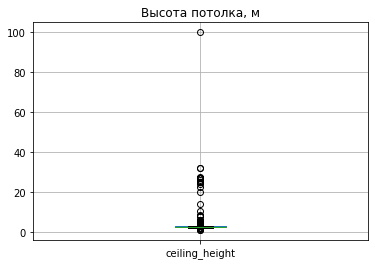

In [4]:
df.plot(
    kind = 'box',
    title = 'Высота потолка, м',
    y = 'ceiling_height',
    grid = True
)

Выбросы есть. Посмотрим подробнее.

27.0     8
25.0     7
8.0      3
32.0     2
5.3      2
20.0     1
24.0     1
26.0     1
5.5      1
14.0     1
22.6     1
5.8      1
27.5     1
100.0    1
10.3     1
5.6      1
8.3      1
5.2      1
6.0      1
Name: ceiling_height, dtype: int64

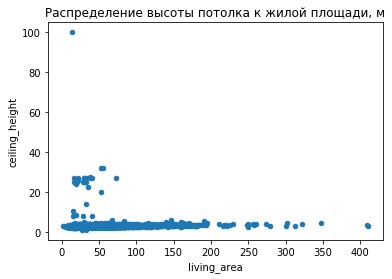

In [5]:
df.plot(
    title = 'Распределение высоты потолка к жилой площади, м',
    x = 'living_area', 
    y = 'ceiling_height',
    kind = 'scatter'
)
df.query('ceiling_height > 5')['ceiling_height'].value_counts()

Видимо, при заполнении высоты неверно указали разрядность и получилось вместо 2.5 метра - 25. Решим это, а все, что выше 10 метров - удалим.

In [6]:
df['ceiling_height'] = df['ceiling_height'].where(df['ceiling_height'] < 10, df['ceiling_height'] / 10)

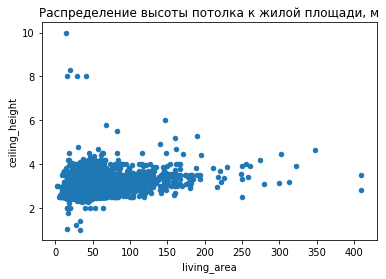

In [7]:
df.plot(
    title = 'Распределение высоты потолка к жилой площади, м',
    x = 'living_area', 
    y = 'ceiling_height',
    kind = 'scatter'
)

От выбросов по высоте потолка избавились.<br>
Заполним медианой.

In [8]:
# Заполнение медианой пустых значений высоты потолка
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].median()

### Проверяем жилую площадь

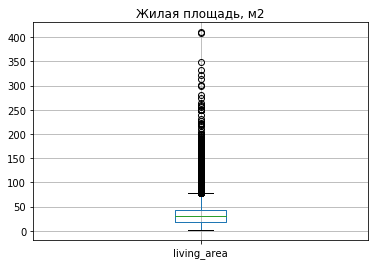

In [9]:
df.plot(
    kind = 'box',
    title = 'Жилая площадь, м2',
    y = 'living_area',
    grid = True
)

Много значений > 100, надо посмотреть подробнее на них. Может действительно есть большие квартиры, а может проблема как и с потолками.

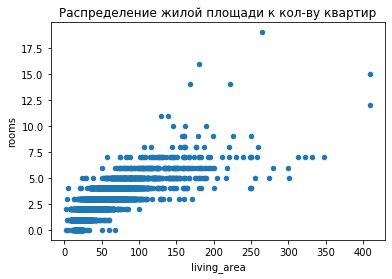

In [10]:
df.plot(
    title = 'Распределение жилой площади к кол-ву квартир',
    x = 'living_area', 
    y = 'rooms', 
    kind = 'scatter'
)

Есть несколько квартир, где количество комнат > 8 и площадь > 180 метров. Вероятно, премиум жилье. При заполнении пустых значений использую медиану - она менее чувствительна к выбросам.

In [11]:
living_median = df['living_area'].median()
kitchen_median = df['kitchen_area'].median()

# Заполнение жилой площади
def fill_living_area(row):
    if row['living_area'] > 0:
        result = row['living_area']

    else:
        if living_median >= row['total_area']:
            if row['kitchen_area'] > 0:
                result = row['total_area'] - row['kitchen_area']
            else:
                result = row['total_area'] - kitchen_median
        else:
            result = living_median - kitchen_median
        

    return result


df['living_area'] = df.apply(fill_living_area, axis = 1)

### Проверяем кухни

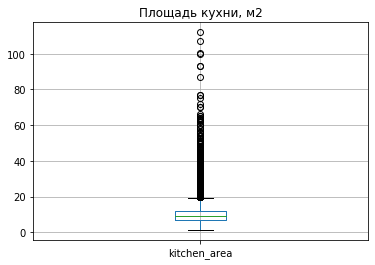

In [12]:
df.plot(
    kind = 'box',
    title = 'Площадь кухни, м2',
    y = 'kitchen_area',
    grid = True
)

Много значений > 20, надо посмотреть подробнее на них. Может действительно есть большие квартиры, а может проблема как и с потолками.

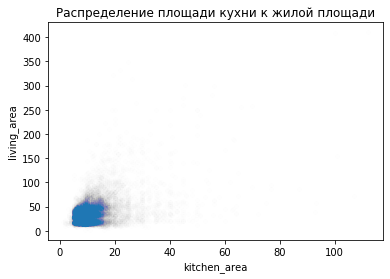

In [13]:
df.plot(
    title = 'Распределение площади кухни к жилой площади', 
    x = 'kitchen_area', 
    y = 'living_area', 
    kind = 'scatter', 
    alpha = 0.005
)

Похоже на то, что большие кухни находятся в больших квартирах  :) <br>
наибольшее скопление размера кухонь в диапазоне 15 метров.<br>
Надо заполнять так же медианой.

In [14]:
# Заполнение площади кухни
def fill_kitchen_area(row):  
    if row['kitchen_area'] > 0:
         result = row['kitchen_area']
            
    else:
        if kitchen_median > (row['total_area'] - row['living_area']):
            result = row['total_area'] - row['living_area']
        else: 
            result = kitchen_median
        
    return result


df['kitchen_area'] = df.apply(fill_kitchen_area, axis = 1)

Text(0, 0.5, 'Количество')

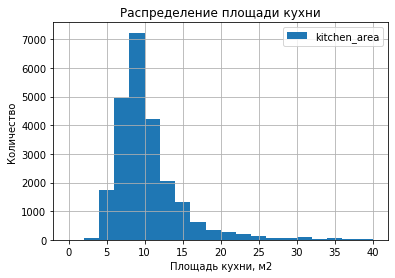

In [15]:
# Распределение размера кухни по количеству
df.plot(
    y = 'kitchen_area',
    kind = 'hist',
    bins = 20,
    range = (0, 40),
    grid = True,
    linewidth = 2
)
plt.title('Распределение площади кухни')
plt.xlabel('Площадь кухни, м2')
plt.ylabel("Количество")

<div style="border:solid green 2px; padding: 20px" > <font size="6" face="Arial" style="color:green; margin-bottom:20px">Комментарий ревьювера #2<font size="3" color='green'> 
<div class="alert alert-block alert-success">
<b>Все ОК:</b> 
    
1. Как прописывать единицы измерения в оси при использовании plot()? Пробовал ylabel, xlabel - постоянно ошибки выдает
    
    - способ который ты пробовал, работает только для pandas версии выше 1.2.XX, тут версия 0.25.ХХ поэтому подписывать необходимо с помощью комманд plt.xlabel(), plt.ylabel()
    
    
2. в .boxplot() нужно ли такое делать? Или boxplot() надо делать через plot(kind = 'box')? Но все равно ошибки выдает при xlabel, ylabel.  
    
    - делать можно как считаешь нужным, это все равно вызывает один и тот же метод только через разные интерфейсы. Чтобы небыло ошибки нужно использовать методы как в предыдущем ответе.
    
    
3. Считается ли график living_area / kitchen_area как несколько переменных? 
    
    - нет, я имел ввиду несколько категорий переменных, ли распределения двух переменнхы
</div>

### Заполняем очевидные пропуски

In [16]:
# Заполннеие нулями пустых значений в балконах и ближайших парков, водоемов
df.loc[df['balcony'].isna(), 'balcony'] = 0
df.loc[df['is_apartment'].isna(), 'is_apartment'] = False
df.loc[df['parks_around3000'].isna(), 'parks_around3000'] = 0
df.loc[df['ponds_around3000'].isna(), 'ponds_around3000'] = 0


# Заполнение значением max() этажа, чтобы сконвертировать тип столбца в int
df.loc[df['floors_total'].isna(), 'floors_total'] = df['floors_total'].max()


# Заполнение 1 (единицей) объявлений, где указано студия
df.loc[(df['rooms'] == 0) & (df['studio'] == True)] = 1
# Заполнение 1 (единицей) объявлений, где указано студия и отсутствует кухня
df.loc[(df['rooms'] == 0) & (df['kitchen_area'].isna())] = 1


# Заполнение общей площадью жилой и кухни в студиях
df.loc[(df['studio'] == True) & (df['kitchen_area'].isna()), 'kitchen_area'] = df['total_area']
df.loc[(df['studio'] == True) & (df['living_area'].isna()), 'living_area']   = df['total_area']

In [17]:
df.query('rooms == 0').loc[:, ['rooms', 'last_price', 'total_area', 'living_area', 'kitchen_area','is_apartment', 'studio', 'open_plan']]

,rooms,last_price,total_area,living_area,kitchen_area,is_apartment,studio,open_plan
349,0,2320000.0,25.00,17.0,8.00,False,False,True
508,0,3375000.0,34.40,24.3,9.10,False,False,True
780,0,2600000.0,26.10,17.0,9.10,False,False,True
839,0,1900000.0,35.00,15.0,9.10,False,False,True
946,0,2200000.0,23.00,18.0,5.00,False,False,True
1574,0,2200000.0,22.00,15.0,7.00,False,False,True
1625,0,1980000.0,23.98,10.5,9.10,False,False,True
2532,0,3500000.0,27.10,18.7,8.40,False,False,True
3019,0,2100000.0,24.00,18.0,6.00,False,False,True
4115,0,2600000.0,24.00,18.0,6.00,False,False,True


Нулями заполнил значения:
- balcony - отсутствие балконов проставилось как Nan.
- is_apartment - булев тип и где стояло Nan, видимо, должно быть False.
- parks_around3000 - скорее всего что парки, что пруды можно заменить на 0, Если Nan
- ponds_around3000



Оставил без изменений:
- airports_nearest
- cityCenters_nearest
- parks_nearest
- ponds_nearest

Поскольку не ясно чем заполнять отсутствующие значения. Эти данные берутся автоматически из акртографического сервиса.
Возможно, сломана интеграция или есть условия выгрузки данных.

Заполнил медианой:
- ceiling_height
- kitchen_area
- living_area

Заполнил 1:
- rooms - там, где 0 комнат и studio = 1.


В объявлениях с открытой планировокой указано 0 комнат. Их оставил без изменений.

In [18]:
df.apply(print_nan, axis = 0)

airports_nearest: 5491; 23.2% 

cityCenters_nearest: 5468; 23.1% 

parks_nearest: 15502; 65.4% 

ponds_nearest: 14499; 61.2% 

days_exposition: 3167; 13.4% 



total_images            None
last_price              None
total_area              None
first_day_exposition    None
rooms                   None
ceiling_height          None
floors_total            None
living_area             None
floor                   None
is_apartment            None
studio                  None
open_plan               None
kitchen_area            None
balcony                 None
locality_name           None
airports_nearest        None
cityCenters_nearest     None
parks_around3000        None
parks_nearest           None
ponds_around3000        None
ponds_nearest           None
days_exposition         None
dtype: object

#### Вывод

После замены пропусков остались столбцы, данные в которые попадают из интеграции.<br>
Так же есть 13,4% пропусков в столбце days_exposition. Это количество дней, пока объявление размещено. 
Если в этом столбце встречается Nan, значит объявление все еще актуально. Можно было бы заполнить расчетом "Сегодня - Дата публикации".

### Приведение типов столбцов таблицы 
<a id="step2-2"></a>

In [19]:
#first_day_exposition    23699 non-null object - дата публикации -> date
#floors_total            23613 non-null float64 - всего этажей -> int -> некоторые значения пропущены, заполню максом из floors.
#balcony                 12180 non-null float64 -> int
#parks_around3000        18181 non-null float64 -> int
#ponds_around3000        18181 non-null float64 -> int
#days_exposition         20518 non-null float64 -> int

df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%d')
df['last_price']       = df['last_price'].astype('int')
df['floors_total']     = df['floors_total'].astype('int')
df['balcony']          = df['balcony'].astype('int')
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null object
studio                  23699 non-null object
open_plan               23699 non-null object
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18208 non-null float64
cityCenters_nearest     18231 non-null float64
parks_around3000        23699 non-null int64
parks_nearest           8197 non-null float64
ponds_arou

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,20.9,9,False,...,9.1,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


#### Вывод

Заменил типы полей, где это было возможно.

Поля, где остались пропуски, остались без изменения.

Заменил тип поля first_day_exposition с object на datetime. С ним потом можно будет работать как с датой и строить графики. Со строкой так делать нельзя.

# Шаг 3. Посчитайте и добавьте в таблицу 
<a id="step3"></a>

## Цена квадратного метра 
<a id="step3-1"></a>

In [20]:
df['square_price'] = (df['last_price'] / df['total_area']).astype('int')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_price
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785
3,0,64900000,159.0,2015-07-24,3,2.65,14,20.9,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000


## День недели, месяц и год публикации 
<a id="step3-2"></a>

In [21]:
df['exposition_day'] = df['first_day_exposition'].dt.day
df['exposition_month'] = df['first_day_exposition'].dt.month
df['exposition_year'] = df['first_day_exposition'].dt.year

df['weekday'] = df['first_day_exposition'].dt.day_name()

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_price,exposition_day,exposition_month,exposition_year,weekday
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,1,482.0,2,755.0,NaN,120370,7,3,2019,Thursday
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0,NaN,0,NaN,81.0,82920,4,12,2018,Tuesday
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,1,90.0,2,574.0,558.0,92785,20,8,2015,Thursday
3,0,64900000,159.0,2015-07-24,3,2.65,14,20.9,9,False,...,2,84.0,3,234.0,424.0,408176,24,7,2015,Friday
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,2,112.0,1,48.0,121.0,100000,19,6,2018,Tuesday


## Соотношение жилой и кухни к общей площади 
<a id="step3-3"></a>

In [22]:
df['living_ratio'] = df['living_area'] / df['total_area']
df['kitchen_ratio'] = df['kitchen_area'] / df['total_area']

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_price,exposition_day,exposition_month,exposition_year,weekday,living_ratio,kitchen_ratio
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2,755.0,NaN,120370,7,3,2019,Thursday,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0,NaN,81.0,82920,4,12,2018,Tuesday,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,2,574.0,558.0,92785,20,8,2015,Thursday,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,2.65,14,20.9,9,False,...,3,234.0,424.0,408176,24,7,2015,Friday,0.131447,0.057233
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1,48.0,121.0,100000,19,6,2018,Tuesday,0.320000,0.410000


## Этаж квартиры; варианты — первый, последний, другой 
<a id="step3-4"></a>

In [23]:
def floor_category(row):
    if row['floor'] == 1:
        result = 'первый'
    elif row['floor'] == row['floors_total']:
        result = 'последний'
    else:
        result = 'другой'
    
    return result

df['floor_category'] = df.apply(floor_category, axis = 1)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,square_price,exposition_day,exposition_month,exposition_year,weekday,living_ratio,kitchen_ratio,floor_category
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,755.0,NaN,120370,7,3,2019,Thursday,0.472222,0.231481,другой
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,81.0,82920,4,12,2018,Tuesday,0.460396,0.272277,первый
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,574.0,558.0,92785,20,8,2015,Thursday,0.612500,0.148214,другой
3,0,64900000,159.0,2015-07-24,3,2.65,14,20.9,9,False,...,234.0,424.0,408176,24,7,2015,Friday,0.131447,0.057233,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,48.0,121.0,100000,19,6,2018,Tuesday,0.320000,0.410000,другой


# Шаг 4. Исследовательский анализ данных 
<a id="step4"></a>

## Изучение площадь, цена, число комнат, высота потолков
<a id="step4-1"></a>

### Площадь

In [24]:
df['total_area'].describe()

count    23699.00000
mean        60.19251
std         35.84693
min          1.00000
25%         40.00000
50%         52.00000
75%         69.80000
max        900.00000
Name: total_area, dtype: float64

In [25]:
df = df.drop(df.loc[df['total_area'] == 1].index)
df['total_area'].describe()

count    23561.000000
mean        60.539209
std         35.663513
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

#### Вывод

В процессе исследования площади объектов, были обнаружены объявления с площадью 1. <br>
При их изучении оказалось, что это скорее всего тестовые данные. Они не релевантные. Удалил.

### Цена

In [26]:
df['last_price'].describe().map('{:.0f}'.format)

count        23561
mean       6561750
std       10914946
min          12190
25%        3450000
50%        4650000
75%        6800000
max      763000000
Name: last_price, dtype: object

Есть очень маленькие и очень большие значения. Надо посмотреть, что за они и, по возможности, избавиться.

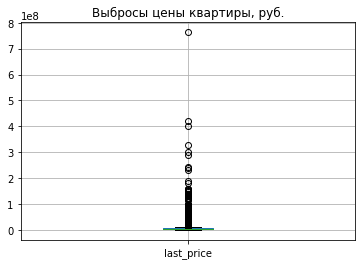

In [27]:
# График с усами посмотреть на выбросы
df.plot(
    title = 'Выбросы цены квартиры, руб.',
    y = 'last_price',
    kind = 'box',
    grid = True
)

Text(0, 0.5, 'Общая площадь, м2')

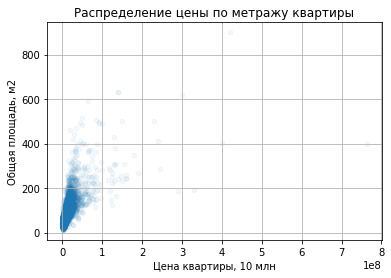

In [28]:
# График распределения, посмотреть на сосредоточенность объектов
df.plot(
    title = 'Распределение цены по метражу квартиры',
    x = 'last_price', 
    y = 'total_area', 
    kind = 'scatter', 
    alpha = 0.05,
    grid = True
)
plt.xlabel('Цена квартиры, 10 млн')
plt.ylabel("Общая площадь, м2")

In [29]:
# сбор сводной таблицы для наглядности цены и цены квадратного метра
agg_price_data = df.pivot_table(index = 'rooms', values = ['last_price', 'square_price'], aggfunc = ['median', 'mean', 'max'])

agg_price_data.columns = ([
    'median_last_price', 
    'median_square_price', 
    'mean_last_price', 
    'mean_square_price', 
    'max_last_price', 
    'max_square_price'])

apartments_count = df.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'count')

# Объединение двух таблиц, чтобы посмотреть каких квартир сколько
agg_price_data = (agg_price_data
                  .join(apartments_count, on = 'rooms')
                  .sort_values(by = 'median_last_price', ascending = False)
)
agg_price_data

,median_last_price,median_square_price,mean_last_price,mean_square_price,max_last_price,max_square_price,last_price
rooms,,,,,,,
12,420000000,466666.0,4.200000e+08,466666.000000,420000000,466666,1
15,65000000,110169.0,6.500000e+07,110169.000000,65000000,110169,1
19,32250000,86091.0,3.225000e+07,86091.000000,32250000,86091,1
16,28500000,105555.0,2.850000e+07,105555.000000,28500000,105555,1
14,26829500,92827.0,2.682950e+07,92827.000000,28659000,116784,2
11,25250000,132639.5,2.525000e+07,132639.500000,33000000,170015,2
7,24900000,108827.0,5.147007e+07,163569.491525,763000000,1907500,59
9,23750000,92517.5,3.415236e+07,105026.875000,88000000,220000,8
8,23095000,106760.0,5.022417e+07,184650.583333,180000000,652173,12


Наибольшее количество квартир до 10 млн.

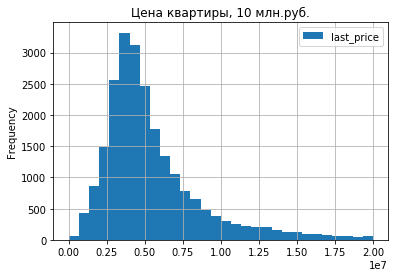

In [30]:
# Посмотрим распределение цены квартиры
df.plot(
    title = 'Цена квартиры, 10 млн.руб.',
    y = 'last_price',
    kind = 'hist',
    bins = 30,
    range = (0, 20000000),
    grid = True,
    linewidth = 2 
)

#### Вывод

При исследовании получилось, что большинство квартир лежит в диапазоне до 10 млн. руб. Основная часть между 2.5 и 7.5 млн.

### Комнаты

In [31]:
df['rooms'].describe().map('{:.2f}'.format)

count    23561.00
mean         2.08
std          1.07
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: object

#### Вывод

С комнатами все в порядке. Большинство 1-4-комнатных квартир.<br>
Есть экземпляр с 19.

Всего 195 квартир, где больше 5 комнат. Также есть квартиры, где 0 комнат. Это объявления с открытой планировкой. Видимо, только коробка продается, без ремонта.

### Высота потолка

In [32]:
df['ceiling_height'].describe().map('{:.2f}'.format)

count    23561.00
mean         2.70
std          0.24
min          1.00
25%          2.60
50%          2.65
75%          2.70
max         10.00
Name: ceiling_height, dtype: object

In [33]:
df.query('ceiling_height < 2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,square_price,exposition_day,exposition_month,exposition_year,weekday,living_ratio,kitchen_ratio,floor_category
5712,5,1500000,42.8,2017-08-14,2,1.20,2,27.5,1,False,...,NaN,248.0,35046,14,8,2017,Monday,0.642523,0.121495,первый
15061,19,5600000,56.4,2018-05-11,2,1.40,14,32.4,5,False,...,NaN,315.0,99290,11,5,2018,Friday,0.574468,0.161348,другой
16934,5,4100000,40.0,2017-10-17,1,1.75,37,17.4,5,False,...,80.0,71.0,102500,17,10,2017,Tuesday,0.435000,0.208500,другой
22309,20,5300000,45.0,2017-09-30,1,1.03,16,15.5,15,False,...,450.0,136.0,117777,30,9,2017,Saturday,0.344444,0.202222,другой
22590,16,6000000,55.0,2018-10-31,2,1.00,12,32.4,7,False,...,289.0,13.0,109090,31,10,2018,Wednesday,0.589091,0.181818,другой


#### Вывод

Есть значение всего одно значение с высотой 1 метр и 4 со значением меньше 2 метров. Это 5 строк. Можно удалить.

In [34]:
df = df.drop(df.loc[df['ceiling_height'] < 2 ].index)

## Гистограммы для каждого параметра
<a id="step4-2"></a>

### Площадь

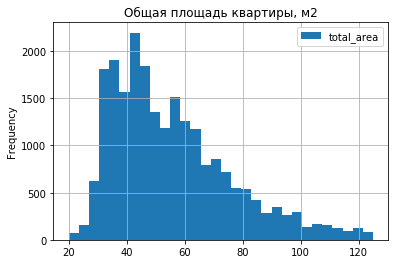

In [35]:
# Посмотрим распределение общей площади квартиры
df.plot(
    title = 'Общая площадь квартиры, м2',
    y = 'total_area',
    kind = 'hist',
    bins = 30,
    range = (20, 125),
    grid = True,
    linewidth = 2 
)

#### Вывод

Распределение нормальное. Большое количество квартир от 30 до 60 метров. Все, что выше 125 можно не учитывать - длинный хвост.

### Цена

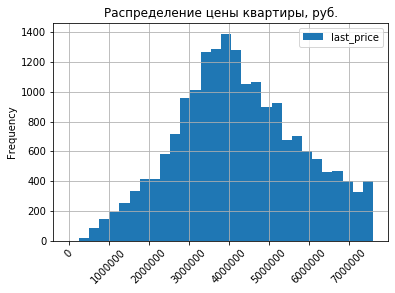

In [36]:
quantiles = df['last_price'].quantile([0.8])

# Посмотрим распределение цены квартиры
df.plot(
    title = 'Распределение цены квартиры, руб.',
    y = 'last_price',
    kind = 'hist',
    bins = 30,
    range = (0, quantiles.iloc[0]), 
    grid = True,
    linewidth = 2,
    rot = 45
)

#### Вывод

Распределение нормальное. Есть длинный хвост высоких цен. <br>
Большинство квартир лежит в диапазоне до 15 млн. Основная масса цены сосредоточена в диапазоне 2.5 - 7.5 млн.

### Комнаты

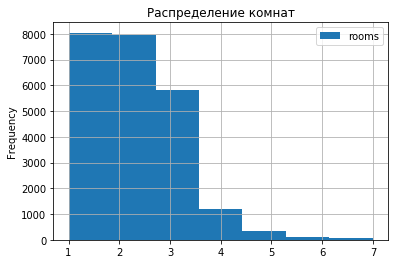

In [37]:
# Посмотрим распределение количества комнат
df.plot(
    title = 'Распределение комнат',
    y = 'rooms',
    kind = 'hist',
    bins = 7,
    grid = True,
    range = (1, 7),
    linewidth = 2
)

#### Вывод

Распределение Пуассона, где отображено наибольшее количество 1-4 комнатных квартир.

### Высота потолка

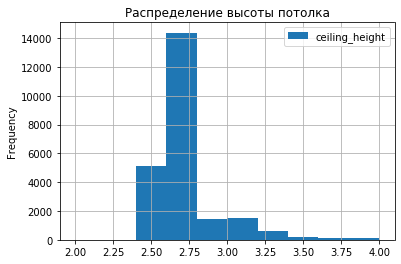

In [38]:
# Посмотрим распределение высоты потолка
df.plot(
    title = 'Распределение высоты потолка',
    y = 'ceiling_height',
    kind = 'hist',
    bins = 10,
    grid = True,
    range = (2, 4),
    linewidth = 2
)

#### Вывод

Нормальное распределение. Больше всего квартир с высотой потолка 2.7 метра, что нормально.

## Время продажи квартиры 
<a id="step4-3"></a>

Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

In [39]:
print('Среднее количество дней: {:.2f}'.format(df['days_exposition'].mean()))
print('Медиана дней: {:.0f}'.format(df['days_exposition'].median()))

Среднее количество дней: 181.24
Медиана дней: 96


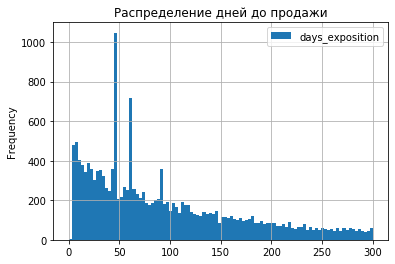

In [40]:
# Посмотрим распределение высоты потолка
df.plot(
    title = 'Распределение дней до продажи',
    y = 'days_exposition',
    kind = 'hist',
    bins = 100,
    grid = True,
    range = (0, 300),
    linewidth = 2
)

#### Вывод

- До 50 дней - очень быстрые.
- От 50 до 100 - быстрые.
- Более 400 дней - необычно долго.

- Среднее число дней до продажи - 96.

## Удаление редких и выбивающихся значений 
<a id="step-4-4"></a>

Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

Будем анализировать основные параметры квартиры: площадь, цена, количество метров, высота потолка, количество комнат.<br>
Начнем с площади

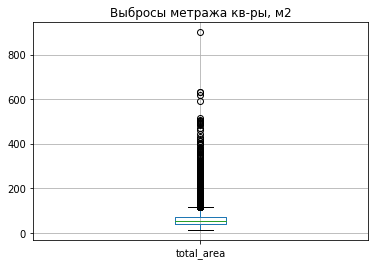

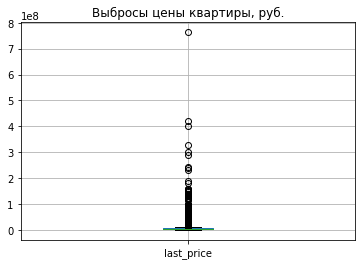

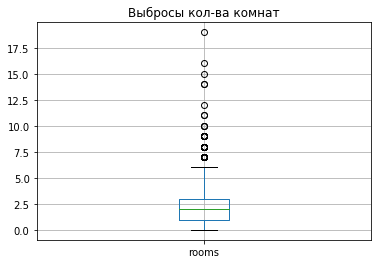

In [41]:
df.plot(
    title = 'Выбросы метража кв-ры, м2',
    y = 'total_area',
    kind = 'box',
    grid = True
)
plt.show()


df.plot(
    title = 'Выбросы цены квартиры, руб.',
    y = 'last_price',
    kind = 'box',
    grid = True
)
plt.show()


df.plot(
    title = 'Выбросы кол-ва комнат',
    y = 'rooms',
    kind = 'box',
    grid = True
)
plt.show()

Получается много выбросов выше основной массы значений, что сказывается на среднем и графиках.<br>

Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

In [42]:
quantiles_last_price = df['last_price'].quantile([0.2, 0.8])
iqr_last_price = quantiles_last_price.iloc[1] - quantiles_last_price.iloc[0]
q1_1 = quantiles_last_price.iloc[1] - 1.5 * iqr_last_price
q3_1 = quantiles_last_price.iloc[1] + 1.5 * iqr_last_price

quantiles_rooms = df['rooms'].quantile([0.2, 0.8])
iqr_rooms = quantiles_rooms.iloc[1] - quantiles_rooms.iloc[0]
q1_2 = quantiles_rooms.iloc[1] - 1.5 * iqr_rooms
q3_2 = quantiles_rooms.iloc[1] + 1.5 * iqr_rooms

quantiles_total_area = df['total_area'].quantile([0.2, 0.8])
iqr_total_area = quantiles_total_area.iloc[1] - quantiles_total_area.iloc[0]
q1_3 = quantiles_total_area.iloc[1] - 1.5 * iqr_total_area
q3_3 = quantiles_total_area.iloc[1] + 1.5 * iqr_total_area


# Фильтруем таблицу по выбросам и собираем новый df
f_df = (df.query(
    '(@q1_1 <= last_price <= @q3_1) and '
    '(@q1_2 <= rooms <= @q3_2) and '
    '(@q1_3 <= total_area <= @q3_3)'
    )
)
f_df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,square_price,exposition_day,exposition_month,exposition_year,weekday,living_ratio,kitchen_ratio,floor_category
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False,...,755.0,NaN,120370,7,3,2019,Thursday,0.472222,0.231481,другой
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,81.0,82920,4,12,2018,Tuesday,0.460396,0.272277,первый
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.3,4,False,...,574.0,558.0,92785,20,8,2015,Thursday,0.612500,0.148214,другой
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.0,13,False,...,48.0,121.0,100000,19,6,2018,Tuesday,0.320000,0.410000,другой
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,55.0,95065,10,9,2018,Monday,0.473684,0.299342,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,9,4600000,62.40,2016-08-05,3,2.60,9,40.0,8,False,...,675.0,239.0,73717,5,8,2016,Friday,0.641026,0.128205,другой
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.0,4,False,...,NaN,45.0,52542,15,1,2018,Monday,0.644068,0.144068,другой
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.7,1,False,...,NaN,NaN,44091,11,2,2018,Sunday,0.523810,0.160494,первый
23697,13,11475000,76.75,2017-03-28,2,3.00,17,20.9,12,False,...,196.0,602.0,149511,28,3,2017,Tuesday,0.272313,0.303583,другой


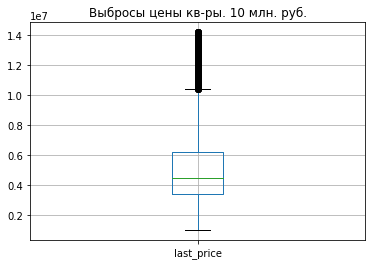

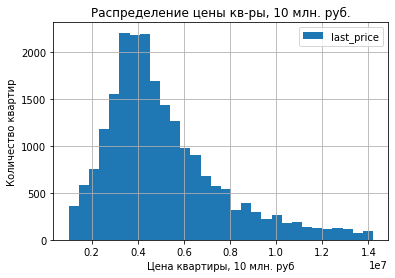

In [43]:
f_df.plot(
    title = 'Выбросы цены кв-ры. 10 млн. руб.',
    y = 'last_price',
    kind = 'box',
    grid = True
)
plt.show()

f_df.plot(
    title = 'Распределение цены кв-ры, 10 млн. руб.',
    y = 'last_price',
    kind = 'hist',
    bins = 30,
    grid = True,
    linewidth = 2
)
plt.xlabel('Цена квартиры, 10 млн. руб')
plt.ylabel('Количество квартир')
plt.show()


In [44]:
f_df['last_price'].describe().map('{:.0f}'.format)

count       21784
mean      5101731
std       2510837
min       1000000
25%       3400000
50%       4500000
75%       6200000
max      14200000
Name: last_price, dtype: object

#### Вывод

Большие выбросы были по цене и жилплощади. Их убрал. Графики с усами стали ровнее.<br>
Остается проблема с ценой - слишком большой диапазон разброса. Но если ограничить гистограмму квартилями, то в целом получается нормальное распределение.

## Факторы стоимости квартиры
<a id="step4-5"></a>

Какие факторы больше всего влияют на стоимость квартиры? <br>
### Зависимость цены от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра.

In [45]:
filter_columns = {
    'Квадратного метра':'square_price', 
    'Количество комнат':'rooms', 
    'Этаж квартиры':'floor', 
    'Удаленность от центра': 'cityCenters_nearest'
}

print('Коэффициенты корреляции к цене')

for column in filter_columns.items():
    print('{}: {:.2f}'.format(column[0], f_df[column[1]].corr(f_df['last_price'])))

Коэффициенты корреляции к цене
Квадратного метра: 0.63
Количество комнат: 0.47
Этаж квартиры: 0.12
Удаленность от центра: -0.36


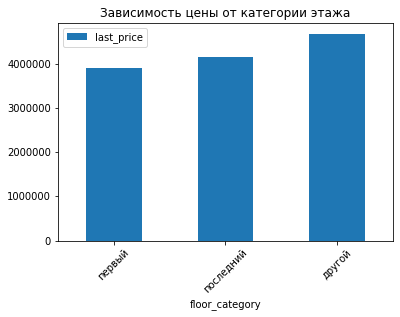

In [46]:
(f_df
 .pivot_table(index = 'floor_category', values = 'last_price', aggfunc = 'median')
 .sort_values(by = 'last_price')
 .plot(title = 'Зависимость цены от категории этажа', y = 'last_price', kind = 'bar', rot = 45)
)

#### Вывод

Удаленность от центра негативно сказывается на цене квартиры.<br>
Цена квадратного метра практически связана с ценой квартиры, что логично. Не понятно, почему 0.6, а не 1.<br>
Меньше всего на цену влияет этаж.<br>
Дороже всего квартиры между первым и последним этажами. Дешевле всего на первом.

### Зависимость от даты размещения: дня недели, месяца и года.

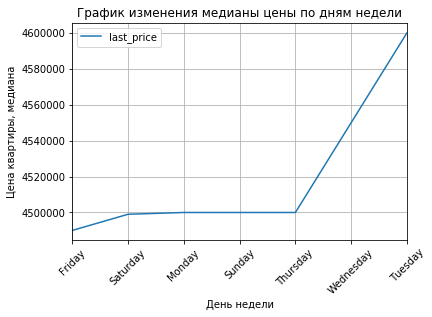

In [47]:
# График дня недели
(f_df
 .pivot_table(index = 'weekday', values = 'last_price', aggfunc = 'median')
 .sort_values('last_price')
 .plot(rot = 45, grid = True)
)
plt.title('График изменения медианы цены по дням недели')
plt.xlabel('День недели')
plt.ylabel('Цена квартиры, медиана')
plt.show()

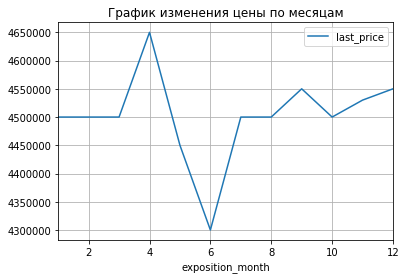

In [48]:
# График месяц
(f_df
 .pivot_table(index = 'exposition_month', values = 'last_price', aggfunc = 'median')
 .sort_values('exposition_month')
 .plot(
     title = 'График изменения цены по месяцам',
     grid = True
 )
)

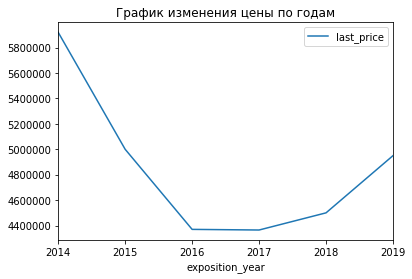

In [49]:
# График года
(f_df
 .pivot_table(index = 'exposition_year', values = 'last_price', aggfunc = 'median')
 .sort_values('exposition_year')
 .plot(
     title = 'График изменения цены по годам'
 )
)

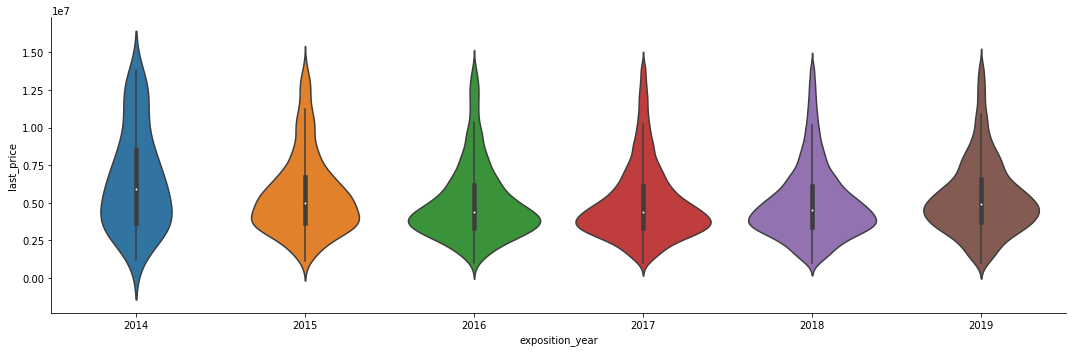

In [50]:
sns.catplot(data = f_df, x = 'exposition_year', y = 'last_price', kind = 'violin', aspect = 3)

#### Вывод

- Во вторник размещают самые дорогие объявления.
- В апреле пик цены, а к лету квартиры дешевеют. К сентябрю снова выходят на среднюю стоимость.
- В период с 14 по 19 год цена просела в 16. После начала постепенно восстанавливаться.

### Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах.

In [51]:
(f_df
 .pivot_table(index = 'locality_name', values ='square_price', aggfunc = ['count', 'mean'])
 .sort_values(by = ('count', 'square_price'), ascending = False)
 .head(10)
)

,count,mean
,square_price,square_price
locality_name,,
Санкт-Петербург,14165,106861.654995
посёлок Мурино,502,85235.117530
посёлок Шушары,436,78405.277523
Всеволожск,389,67263.218509
Пушкин,343,100786.297376
Колпино,337,75332.866469
посёлок Парголово,325,90430.298462
Гатчина,303,69110.508251


### Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

In [52]:
(f_df
 .pivot_table(index = 'locality_name', values = 'last_price', aggfunc = ['min', 'max'])
 .sort_values(by = ('max', 'last_price'), ascending = False)
 .head(10)
)

,min,max
,last_price,last_price
locality_name,,
Санкт-Петербург,1200000,14200000
Сестрорецк,2800000,13999000
Гатчина,1050000,13900000
Пушкин,1990000,13300000
деревня Кудрово,2100000,13000000
посёлок Стрельна,2550000,12990000
Кудрово,2350000,12800000
Петергоф,2100000,12790000


### Изучение предложения квартир по расстоянию до центра

Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. 
- [x] Выделите квартиры в Санкт-Петербурге ('locality_name'). 
- [x] Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. 
- [x] После этого посчитайте среднюю цену для каждого километра. 
- [x] Постройте график: он должен показывать, как цена зависит от удалённости от центра. 
- [x] Определите границу, где график сильно меняется — это и будет центральная зона.

In [59]:
def fill_cityCentre_km(row):
    if row['cityCenters_nearest'] > 0:
        result = row['cityCenters_nearest'] / 1000
    else:
        result = -1
    
    return result


spb_df = f_df
spb_df['cityCentres_km'] = (f_df
                          .query('locality_name == "Санкт-Петербург"')
                          .apply(fill_cityCentre_km, axis = 1)
                          .astype('int')
                         )

spb_df = f_df.query('cityCentres_km > 0')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
(spb_df
 .pivot_table(index = 'cityCentres_km', values = 'square_price')
 .plot(
     title = 'Распределение цены кв. метра пир удалении от центра "{locality_name}"',
     kind = 'bar', 
     figsize = (20, 10)
 )
)

In [ ]:
(spb_df
 .pivot_table(index = 'cityCentres_km', values = ['square_price', 'last_price'])
 .plot(
     title = ('Распределение цены кв. метра от центра города', 'Распределение цены от центра города'),
     kind = 'bar', 
     figsize = (20, 10), 
     subplots = True
 )
)

#### Вывод

Выглядит так, что центральная зона это 0-3 км.

### Сегмент квартир в центре

- [x] Выделите сегмент квартир в центре. 
- [x] Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. 
- [x] Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). 
- [ ] Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [ ]:
filter_columns = ['total_area', 'last_price', 'rooms', 'ceiling_height']

for column in filter_columns:
    spb_df.hist(column)
    plt.show()

#### Вывод

Нормальное распределение, нет выбросов или смещения. Высота потолка имеет распределение Пирсона, что тоже ок.

In [ ]:
columns = [
    'square_price',
    'total_area', 
    'last_price', 
    'rooms', 
    'ceiling_height',
    'floor', 
    'cityCentres_km'
]
data = spb_df.corr()

spb_corr_df = pd.DataFrame(data = data, columns = columns)
#pd.plotting.scatter_matrix(spb_corr_df, figsize = (20, 20))

In [ ]:
filter_columns = {
    'Общая площадь' : 'total_area',
    'Цена квартиры' : 'last_price',
    'Цена кв. метра' : 'square_price',
    'Количество комнат':'rooms',
    'Высота потолка':'ceiling_height',
    'Этаж квартиры':'floor',
    'Удаленность от центра': 'cityCentres_km'
}


spb_center = spb_df.query('cityCentres_km <= 3')
spb_not_center = spb_df.query('cityCentres_km > 3')


print('Коэффициенты корреляции к цене кв метра')
for column in filter_columns.items():
    print('В центре -- {}: {:.2f}'.format(column[0], spb_center[column[1]].corr(spb_center['square_price'])))
    print('НЕ в центре -- {}: {:.2f}'.format(column[0], spb_not_center[column[1]].corr(spb_not_center['square_price'])))
    print()

В центре отрицательная корреляция к общей площади. Что это значит? Чем меньше площадь, тем дороже квартира чтоли?<br>
Вне центра растет корреляция общей цены. <br>
Вне центра больше корреляция высоты потолка и этажа квартиры. Возможно, дело в типе застройки в центре - она однотипная и нет разбежки в цене поэтому.

In [ ]:
def categorize_distance(value):
    if value >= 4 and value <= 10:
        return '4-10 км'
    elif value >= 11 and value <= 20:
        return '11-20 км'
    else:
        return '21-30 км'


spb_df.loc[:, 'distance_category'] = spb_df['cityCentres_km'].apply(categorize_distance)


for column in filter_columns.items():
    if column[1] not in ('cityCentres_km'):
        sns.catplot(
            data = spb_df.query('cityCentres_km > 3'),
            x = 'distance_category',
            y = column[1],
            kind = 'violin',
            aspect = 3
        )

In [ ]:
for column in filter_columns.items():
    if column[1] not in ('cityCentres_km'):
        sns.catplot(
            data = spb_df.query('cityCentres_km <= 3'),
            x = 'cityCentres_km',
            y = column[1],
            kind = 'violin',
            aspect = 3
        )

### Шаг 5. Общий вывод

1. Этаж: в центре преимущественно квартиры на 2 - 4 этаже. Возможно, дело в этажности застройки.
2. Высота потолка: 2.7 метра.
3. Кол-во комнат: в центре преимущественно 2-3 комнатные квартиры, по всему городу добавляются однушки.
4. Цена кв. метра: в центре от 75 до 125 тыс. руб. Большинство в районе 110 тыс.; не в центре от 80 до 120 тыс. руб. Большинство сосредоточено в районе 100 тыс.
5. Общая цена: в центре от 6 до 12 млн. руб.; не в центре от 3 до 8 млн. руб.
6. Общая площадь: в центре 60-80 м2.; не в центре 35-60 м2. Это связано с тем, что не в центре появляются однокомнатные квартиры, у окторых общая площадь маленькая.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод